<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab08_automatic-gradient-training-loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 - Automatic Gradient Training Loop

### Author: Szymon Nowakowski

An **ellipse** is a geometric shape defined as the set of all points where the sum of the distances to two fixed points, called **foci**, remains constant. This fundamental property can be expressed mathematically as:

$$
d_1 + d_2 = C
$$

where $d_1$ and $d_2$ are the distances from a point on the ellipse to each focus, and $C$ is a fixed constant.

To reconstruct an ellipse through optimization, we begin with **$N$ points** scattered randomly in the 2D plane. Our goal is to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieve this by minimizing the **Mean Squared Error (MSE) loss**, $L_{\text{ellipse}}$, defined as:

$$
L_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} (d_{i1} + d_{i2} - C)^2
$$

where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci. By iteratively updating the point positions using gradient descent, we minimize $L_{\text{ellipse}}$, thereby ensuring that the points progressively align with the shape of an ellipse.

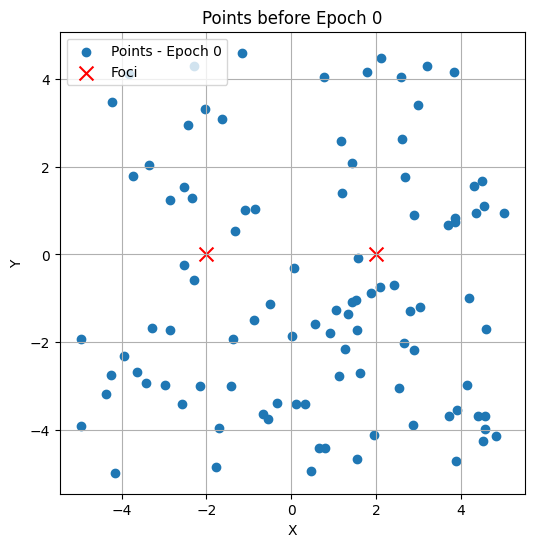

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True



def plot_results(epoch, trajectories, loss_history=None):
    if loss_history is not None:
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
      fig, axes = plt.subplots(1, 1, figsize=(6, 6))
      axes = [axes]
    points = np.array([trajectories[i][-1] for i in range(num_points)])
    # Left plot: Scatter of points with trajectories
    axes[0].scatter(points[:, 0], points[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()


    axes[0].grid()

    if loss_history is not None:
      axes[0].set_title(f'Points after Epoch {epoch}')
      # Right plot: Loss history
      axes[1].plot(loss_history, color='blue')
      axes[1].set_xlabel("Epoch")
      axes[1].set_ylabel("Loss")
      axes[1].set_title("Loss Convergence")
      axes[1].grid()
    else:
      axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []

for i in range(num_points):
    trajectories[i].append(points[i].detach().cpu().clone().numpy())

plot_results(0, trajectories, None)


# TASK 1: **Training loop**
---------------------------------------
Now your job is to rewrite the training loop by adding the actual working code into the `#TODO` sections.

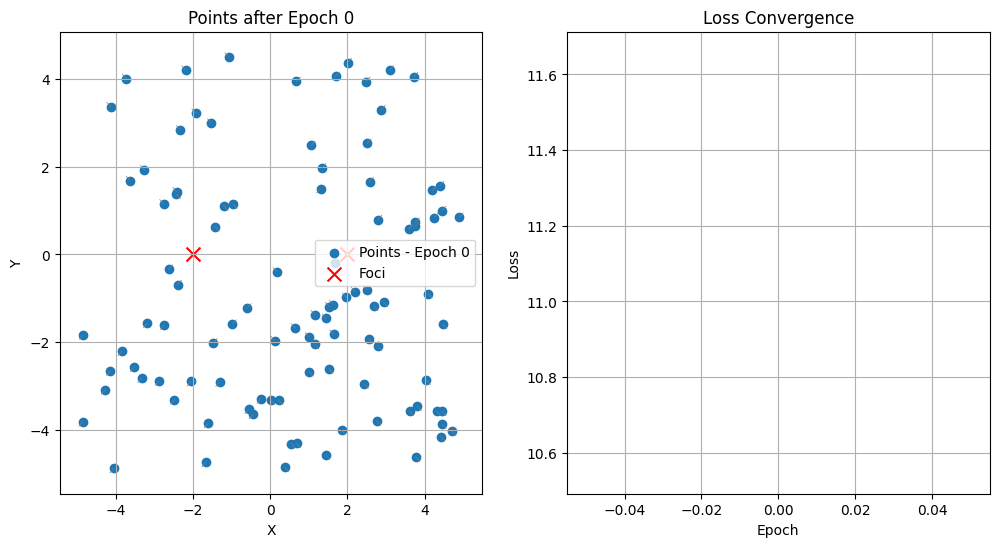

Epoch 0: Loss = 11.102331


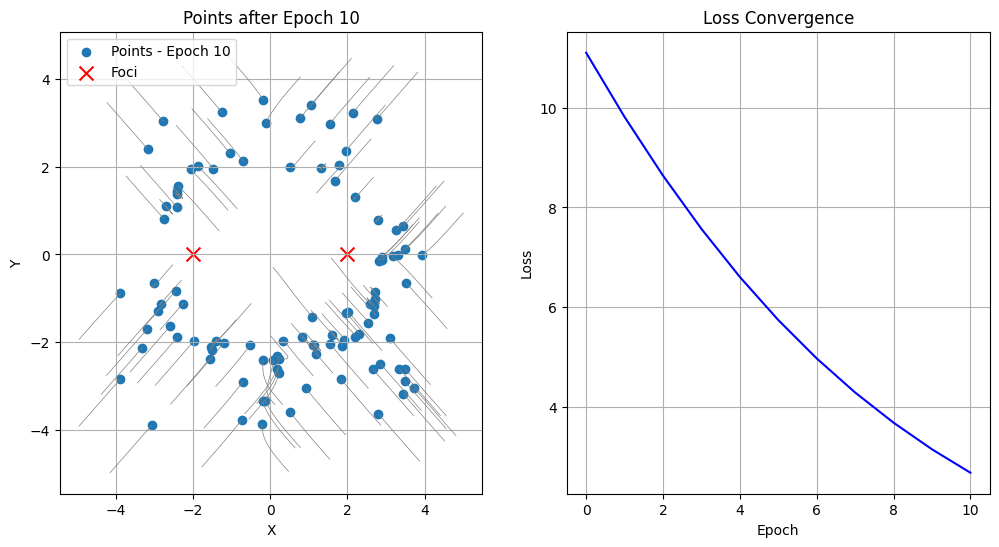

Epoch 10: Loss = 2.679706


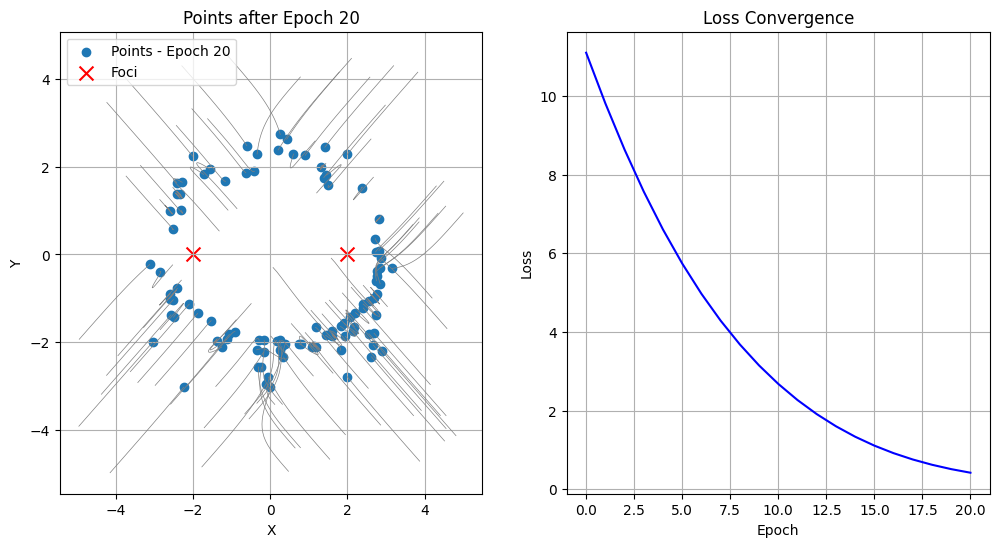

Epoch 20: Loss = 0.420637


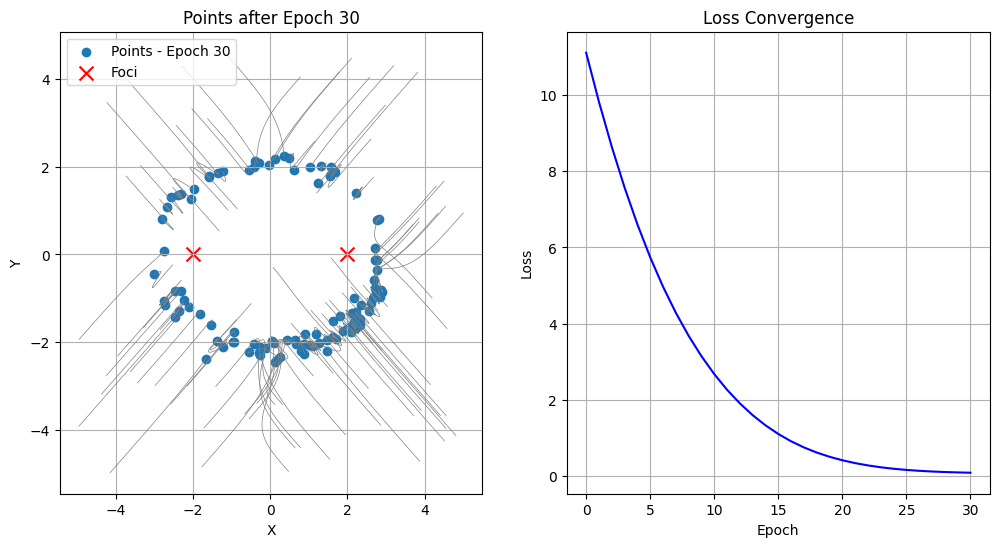

Epoch 30: Loss = 0.094077


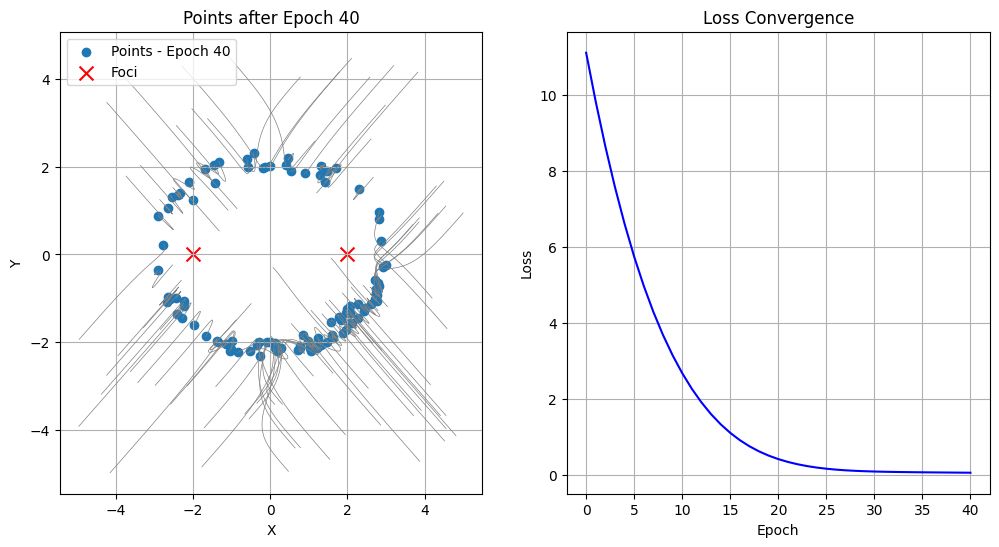

Epoch 40: Loss = 0.062468


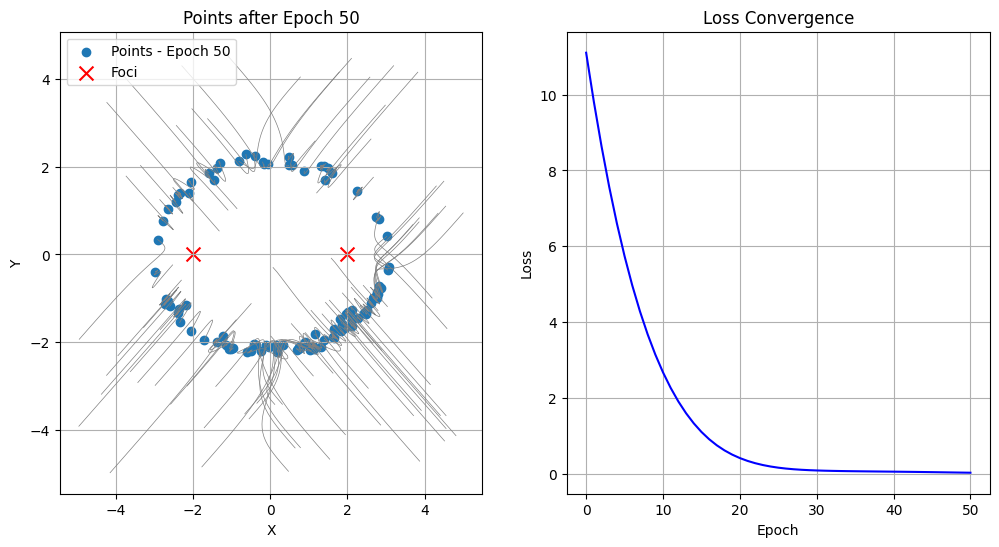

Epoch 50: Loss = 0.034578


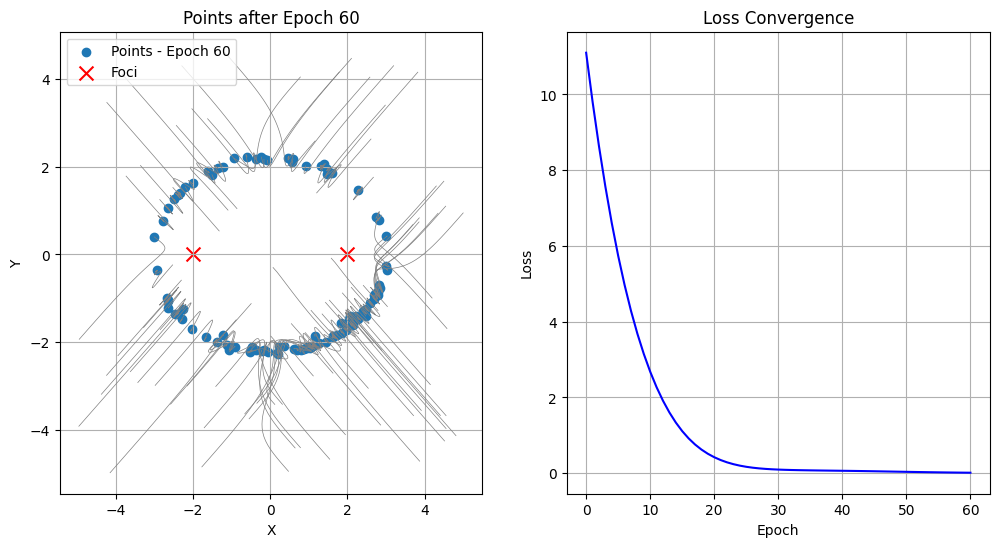

Epoch 60: Loss = 0.011165


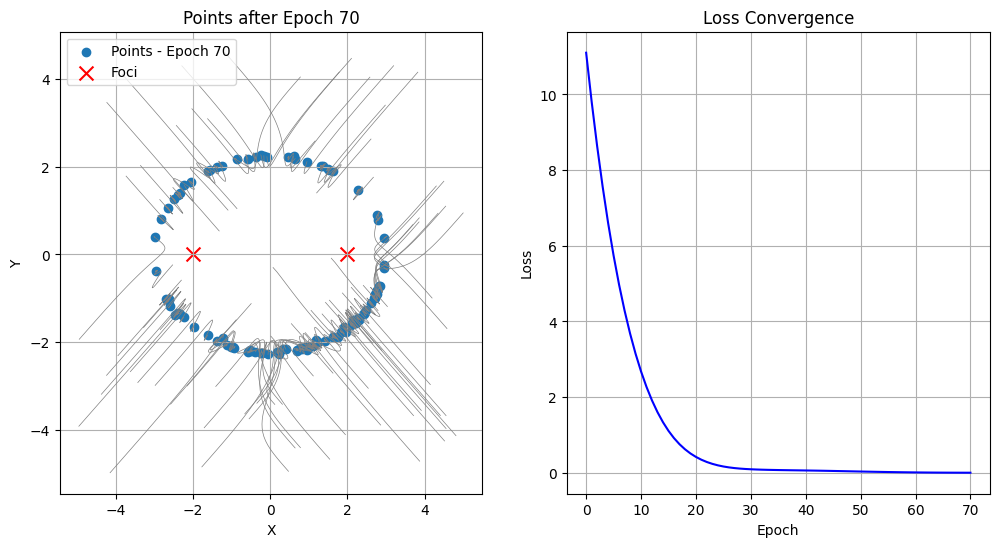

Epoch 70: Loss = 0.002952


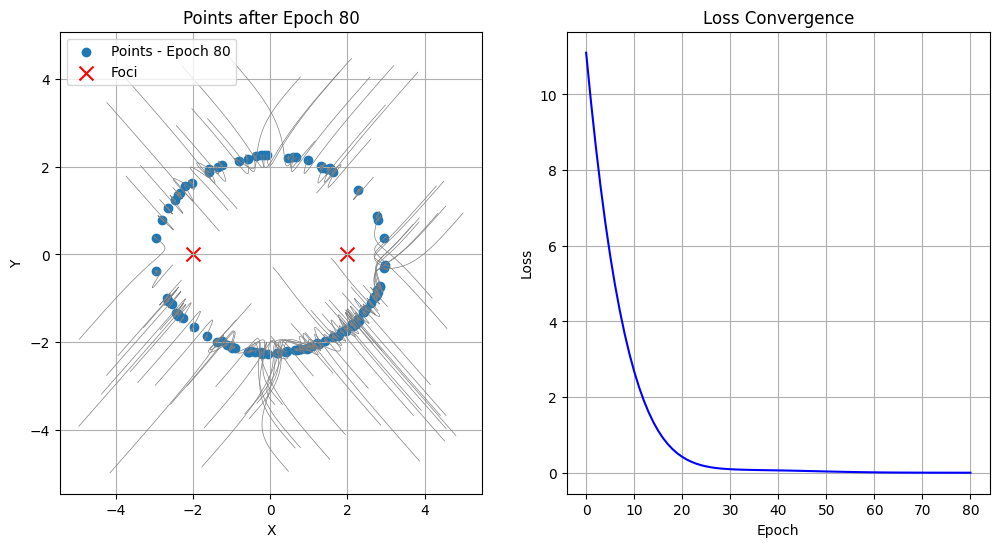

Epoch 80: Loss = 0.001104


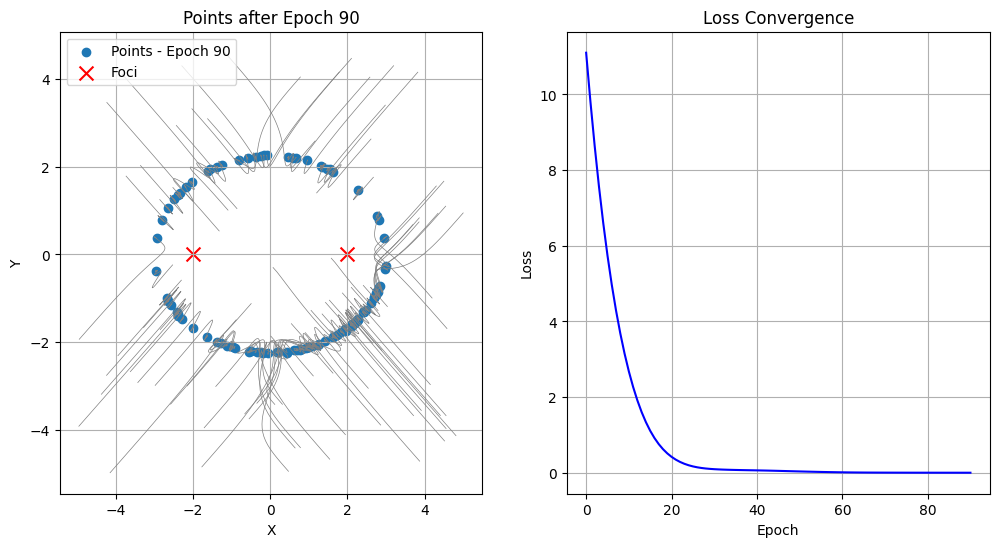

Epoch 90: Loss = 0.000479


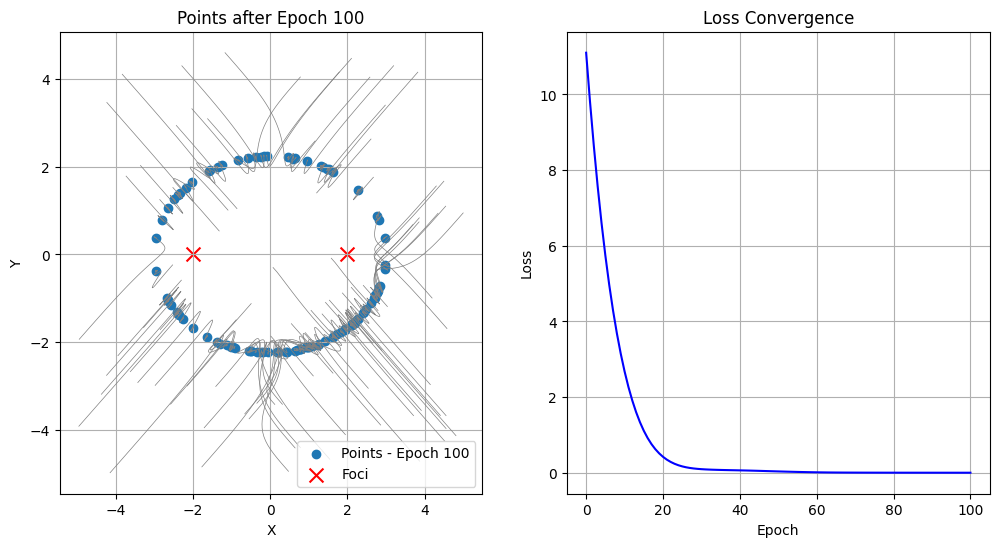

Epoch 100: Loss = 0.000153


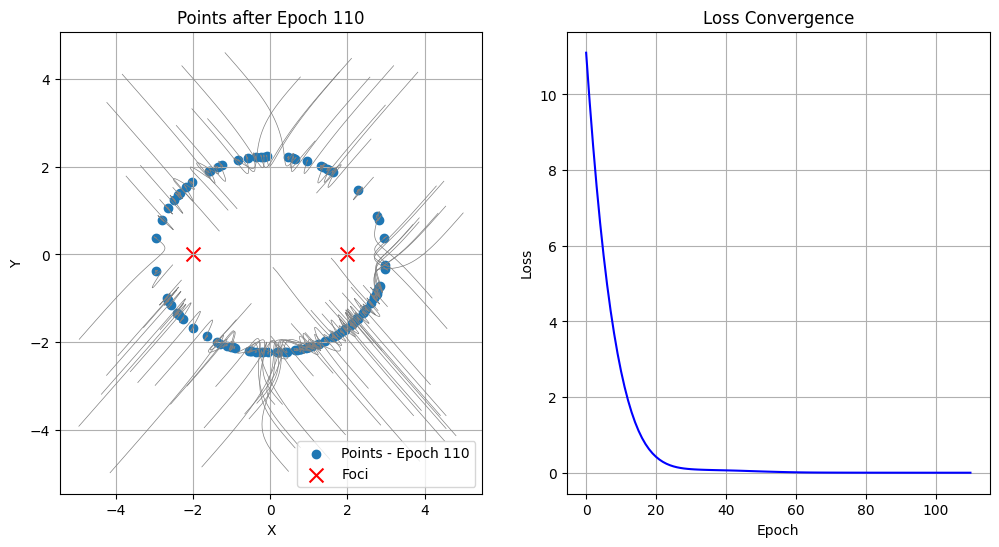

Epoch 110: Loss = 0.000052


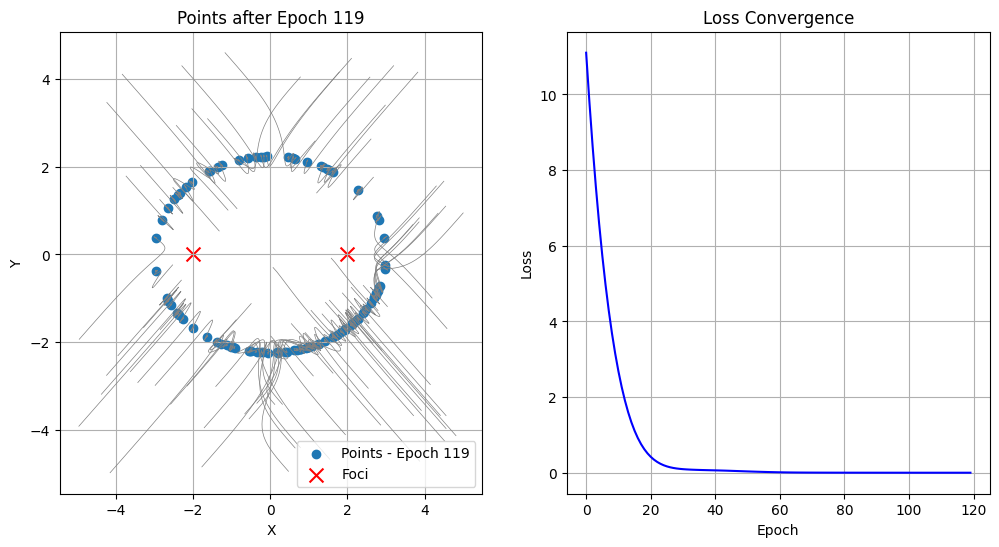

Elapsed time: 5.66843581199646 seconds


In [13]:
import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 120
for epoch in range(num_epochs):

    optimizer.zero_grad()

    d1 = torch.norm(points - focus1,dim=1)
    d2 = torch.norm(points - focus2,dim=1)
    loss = torch.mean((d1 + d2 - constant_sum) ** 2)
  
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)


# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# TASK 2: **Move computations to GPU**
-------------------------

To accelerate the optimization process, we can move the computation to the GPU, leveraging the parallel processing capabilities of modern hardware. In PyTorch, this is done by transferring tensors and models to a CUDA-enabled device using `.to("cuda")` or `.cuda()` or `device = "cuda"`. The loss function remains unchanged, but all operations, including distance calculations and gradient updates, are performed on the GPU.

Move the computations to CUDA. Make sure, your working environment supports CUDA.

**Note the speedup in computations once you've completed this task**.

In [17]:
# Reinitialize everything, but on CUDA

# Check availability of CUDA
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f"Working on {device}")

torch.manual_seed(42)
np.random.seed(42)


# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0]).to(device)  # First focus
focus2 = torch.tensor([2.0, 0.0]).to(device)   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = (torch.rand((num_points, 2)) * 10 - 5).to(device)  # Uniformly distributed in [-5, 5]
points.requires_grad = True

points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []

Working on cuda


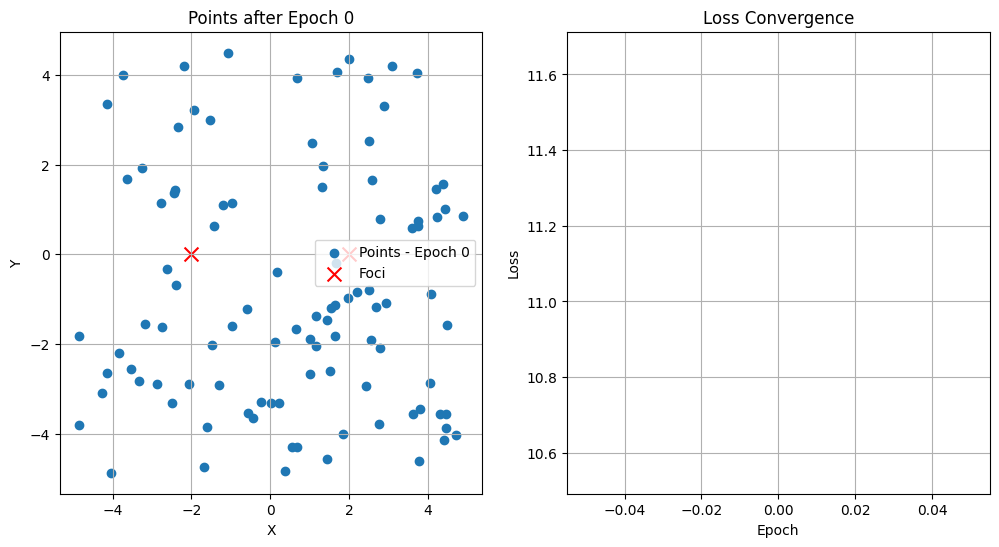

Epoch 0: Loss = 11.102330


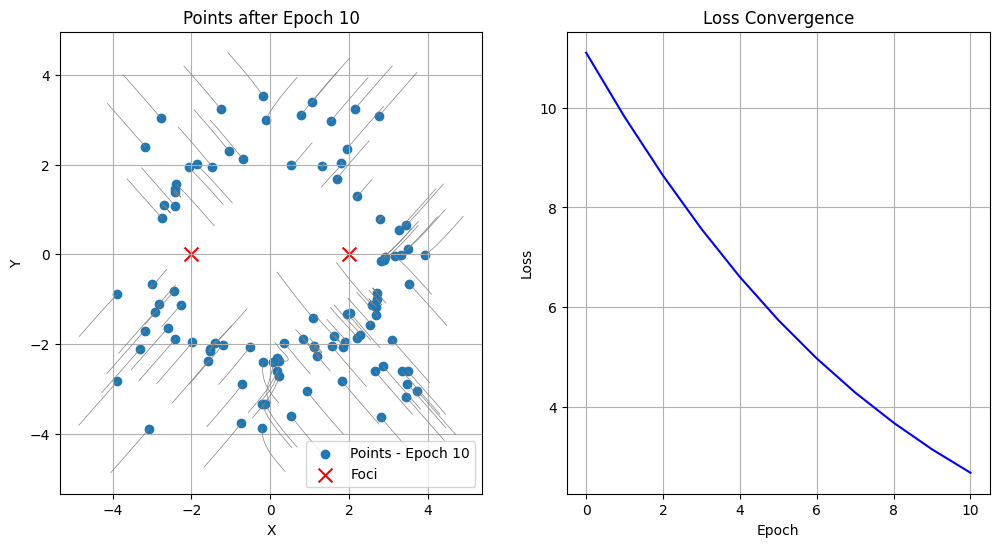

Epoch 10: Loss = 2.679705


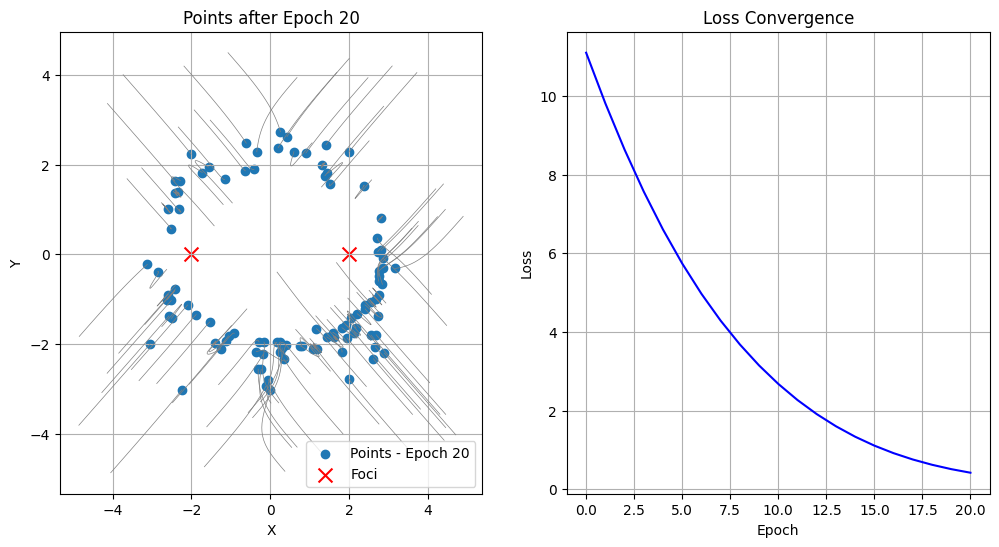

Epoch 20: Loss = 0.420637


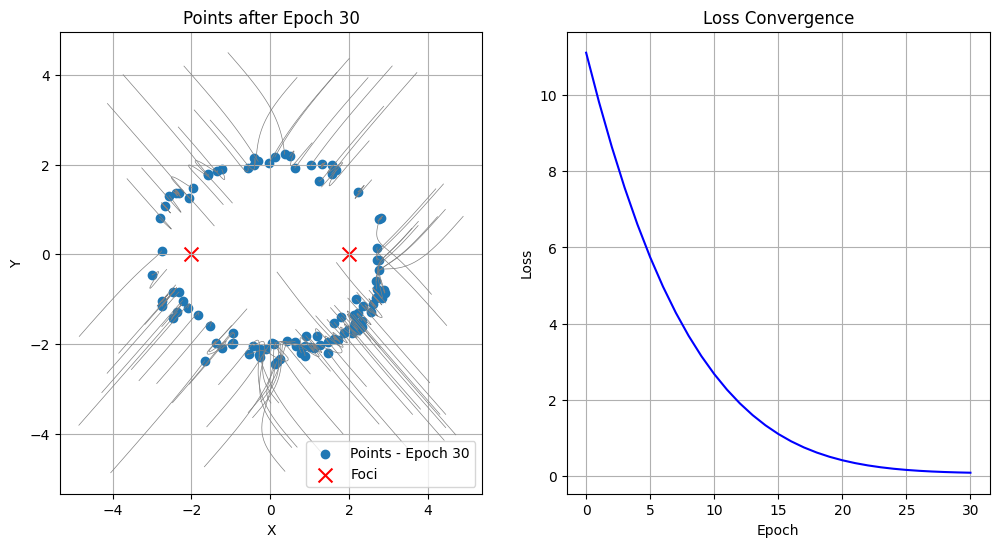

Epoch 30: Loss = 0.094077


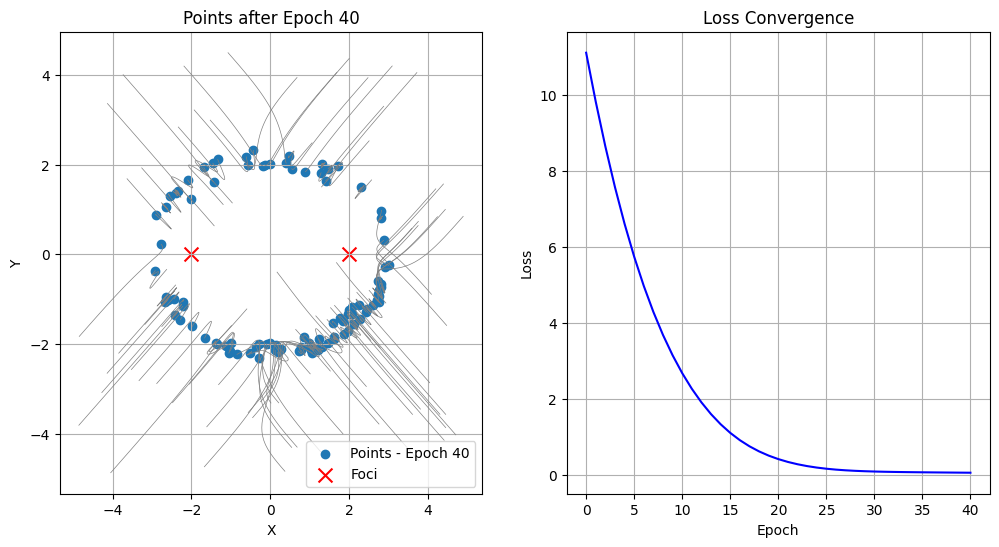

Epoch 40: Loss = 0.062468


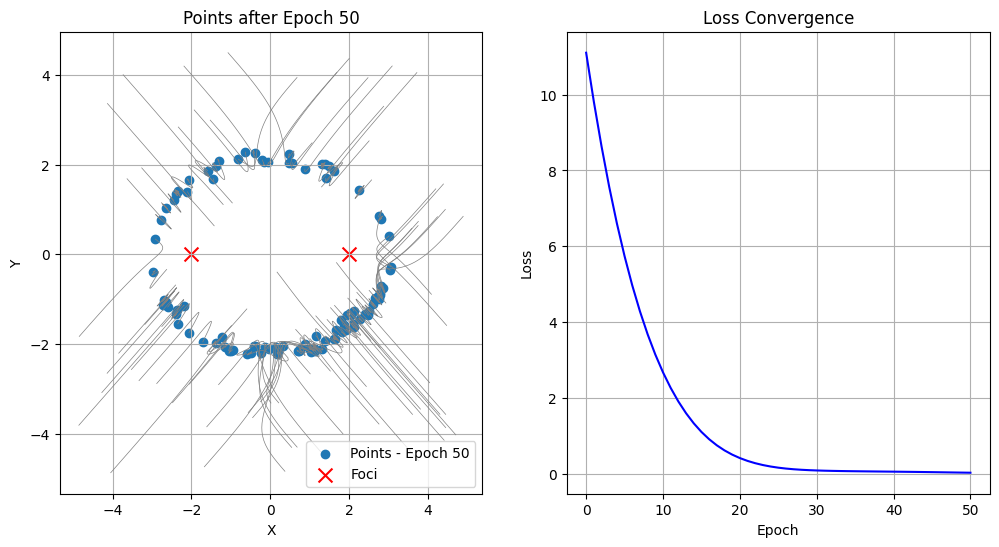

Epoch 50: Loss = 0.034578


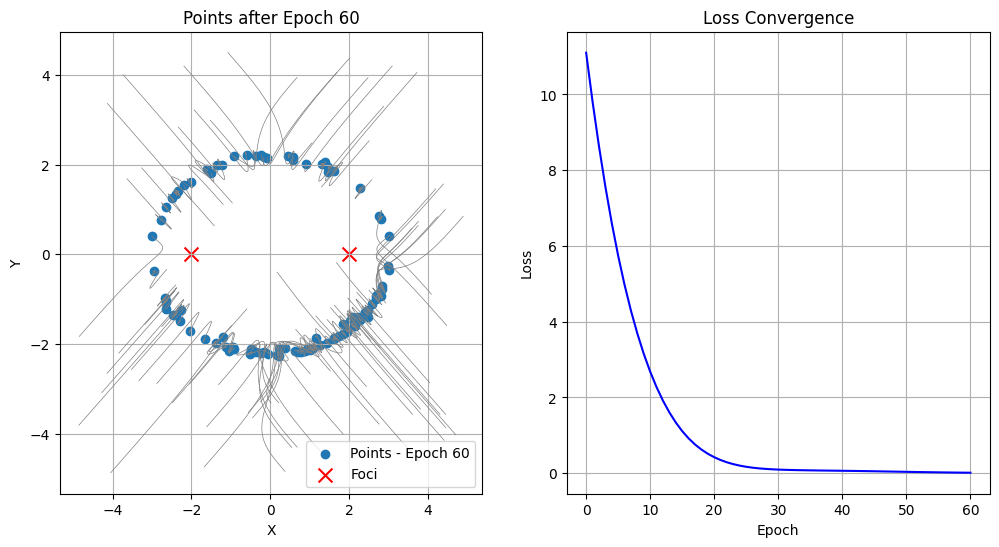

Epoch 60: Loss = 0.011165


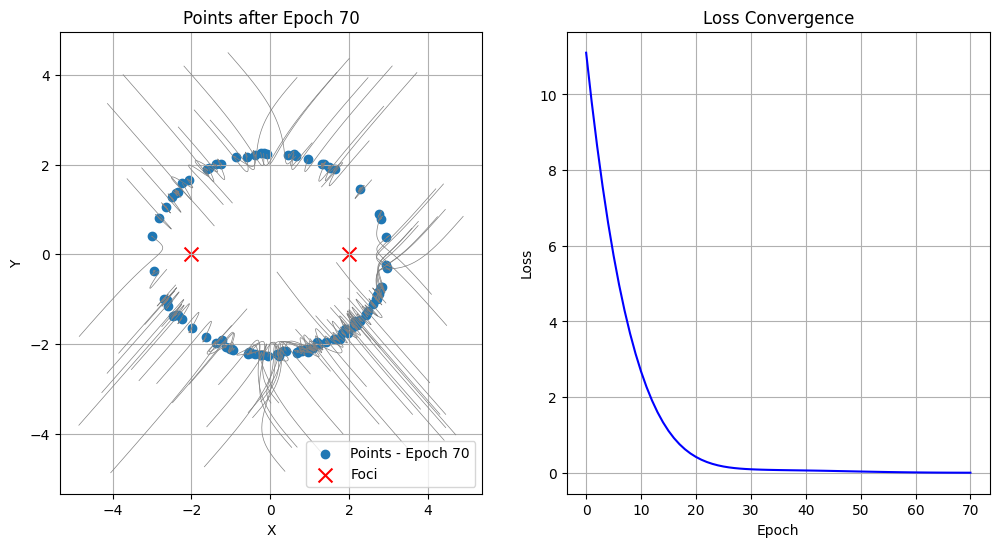

Epoch 70: Loss = 0.002952


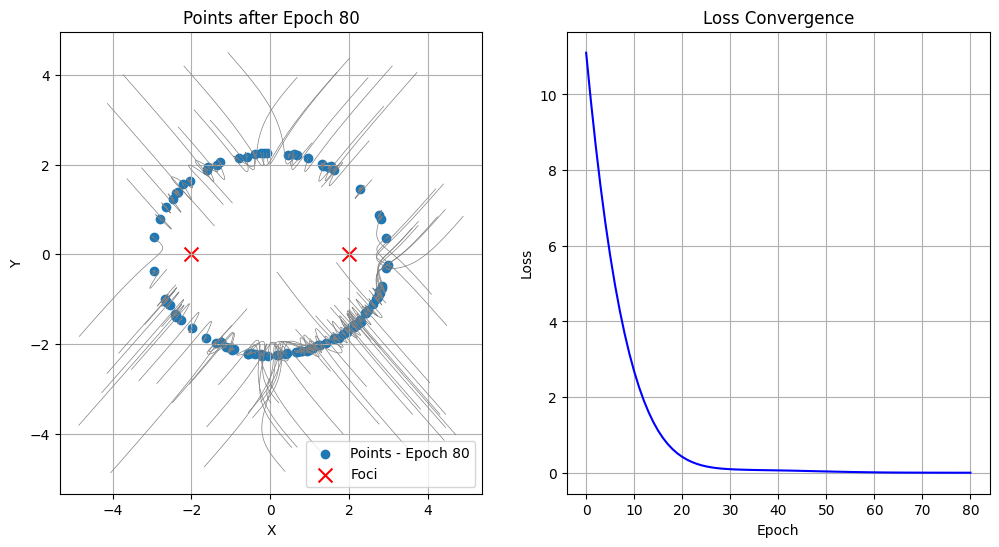

Epoch 80: Loss = 0.001104


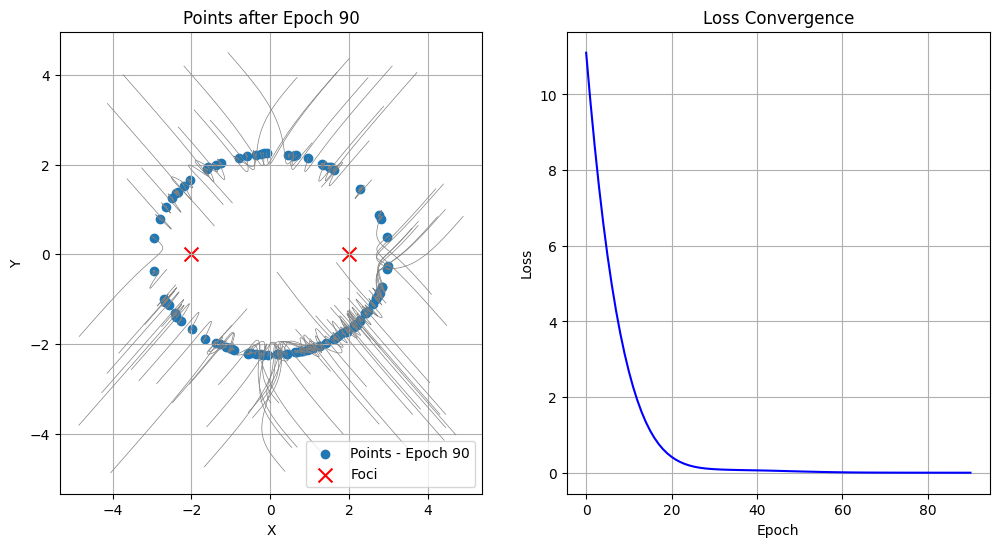

Epoch 90: Loss = 0.000479


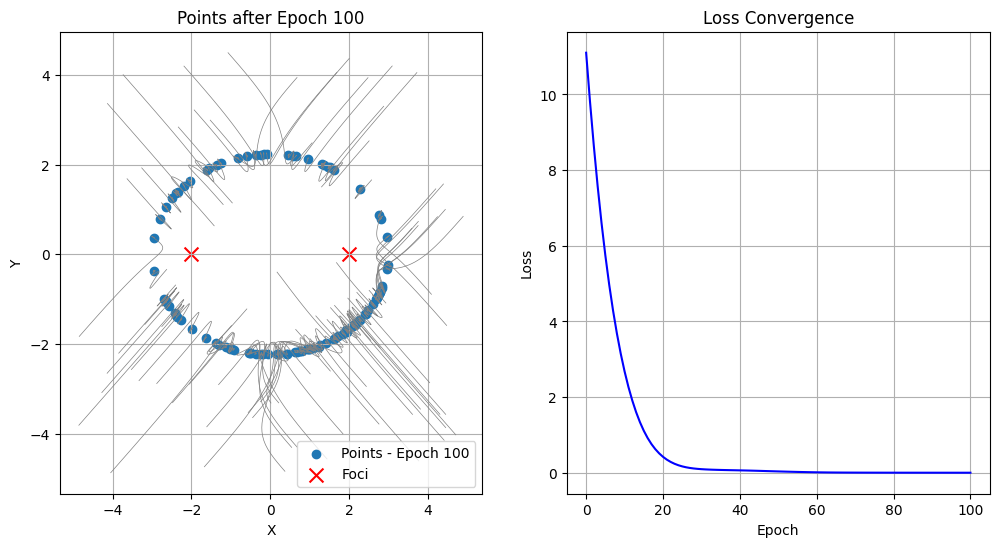

Epoch 100: Loss = 0.000153


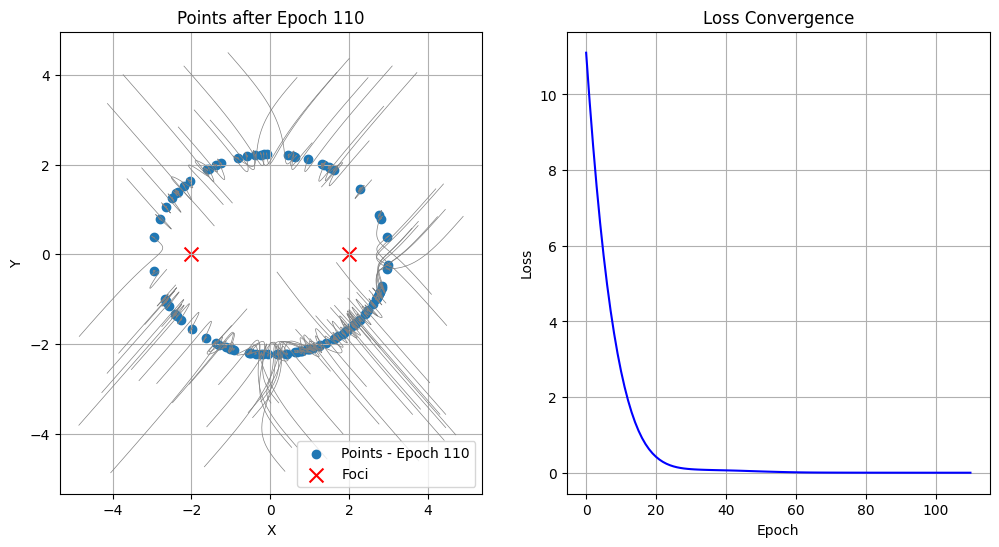

Epoch 110: Loss = 0.000052


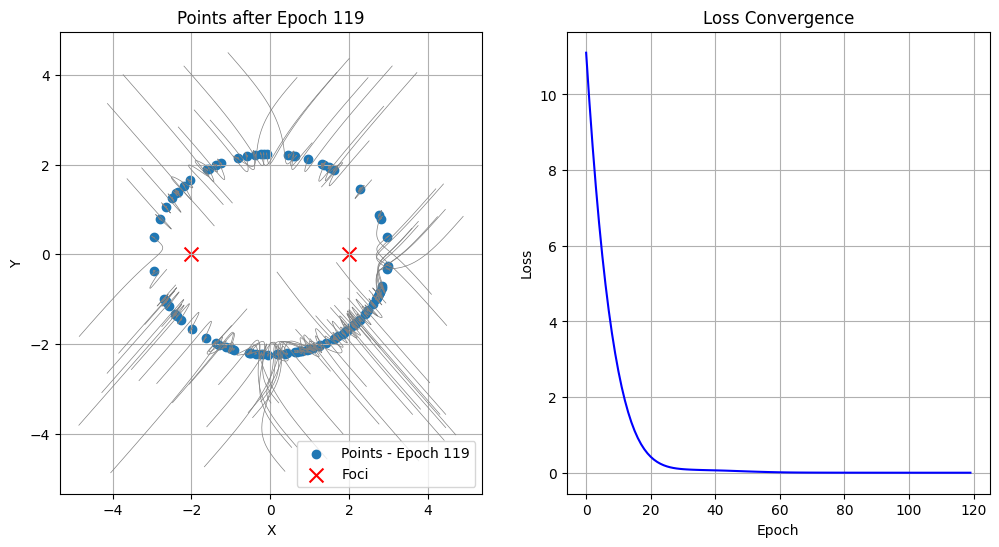

Elapsed time: 6.213351726531982 seconds


In [18]:
import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 120
for epoch in range(num_epochs):

    optimizer.zero_grad()

    d1 = torch.norm(points - focus1,dim=1)
    d2 = torch.norm(points - focus2,dim=1)
    loss = torch.mean((d1 + d2 - constant_sum) ** 2)
  
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)

# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# TASK 3: **Add the repulsion penalty.**
--------------------------



To prevent points from clustering too closely, we introduce a repulsion penalty to the loss function. This term discourages points from being too close to one another by penalizing small pairwise distances. The updated loss function consists of two components: the original ellipse loss $L_{\text{ellipse}}$ and the repulsion penalty $L_{\text{repulsion}}$. The total loss is given by:

$$
L = L_{\text{ellipse}} + \lambda L_{\text{repulsion}}
$$

where $\lambda$ is a hyperparameter controlling the strength of the repulsion term. The repulsion loss is defined as:

$$
L_{\text{repulsion}} = \sum_{i \neq j} \frac{1}{(\| p_i - p_j \|^2 + \epsilon)}
$$

where $p_i$ and $p_j$ are the positions of the points, and $\epsilon$ is a small constant to prevent division by zero. By including this term, we ensure that points remain well-distributed along the ellipse while still minimizing $L_{\text{ellipse}}$. This results in a more evenly spaced set of points that better capture the desired elliptical shape.

In [16]:
# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)
lambda_repulsion = 0.001  # Weight for repulsion term



# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss for ellipse constraint
    loss_ellipse = torch.mean((dist1 + dist2 - constant_sum) ** 2)

    #------------------------------------
    # Compute repulsion loss
    #------------------------------------
    ''' double for loop, extremely nonefficient

    repulsion_loss = 0.0
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = torch.norm(points[i] - points[j])
            repulsion_loss += 1.0 / (distance ** 2 + 1e-6)  # Avoid division by zero
    '''
    # TODO: Compute all pairwise distances in parallel

    # Avoid self-interactions (diagonal elements should be ignored)
    distances = distances + torch.eye(num_points, device=points.device) * 1e6  # Large value to effectively "remove" diagonal
                                                        # Shape: (N, N)
    # TODO: Compute inverse-square repulsion penalty by averaging the matrix or summing the matrix

    # TODO: Normalize by number of pairs to keep scale consistent (if needed)

    # Total loss
    loss = loss_ellipse + lambda_repulsion * repulsion_loss
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


#Final plot
plot_results(epoch, trajectories, loss_history)

NameError: name 'distances' is not defined

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

1. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

1. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

## **Points to Note**

1. Draw both the shape that the points draw as they move, and the loss value after each epoch, just as we did in class today.

2. Note, that the purpose of this excercise is not that you reconstruct a perfect ellipse, but rather that you give it a try, and even if you fail you should document and explain the failure, and answer a question related to a given loss definition.

3. You can also play around with the learning rate to try to improve convergence.

## **Task & Deliverables**
  
   - Document your experiments (python code and charts) and **write down your conclusions** into the Colab notebook.
   - It is not strictly required, but **if you make a movie showing the optimization progress it will be considered a strong point of your solution**
     - You can make a movie programmatically as we did in clustering class (our second class) with EM clustering,
     - or, you can save to disk the image files with epoch charts and use an external tool to bind them into a movie. Provide links to movie files in the README.
   - Place the Colab notebook  with the solution in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook (and any movies you created) and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.

## Sample code

   You can use the sample code provided below:



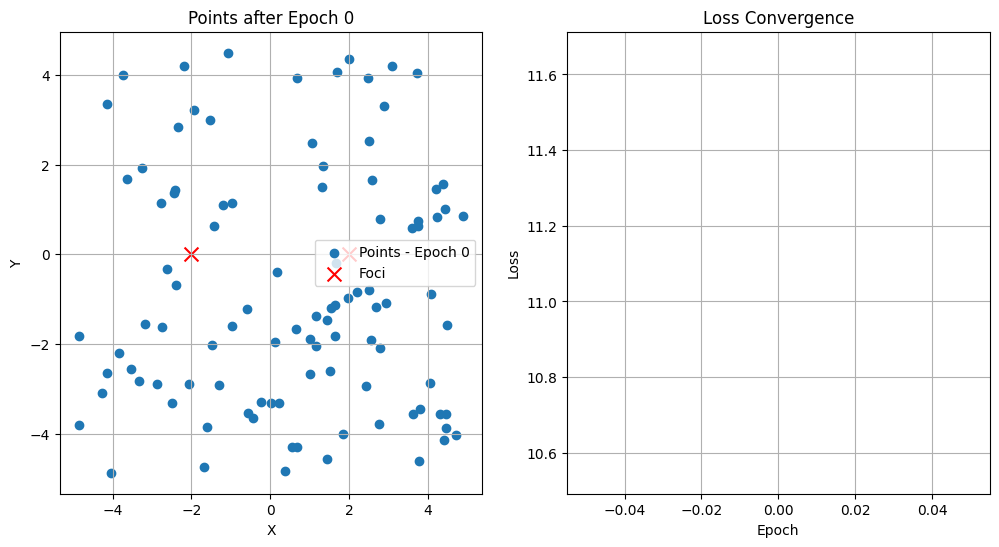

Epoch 0: Loss = 11.102331


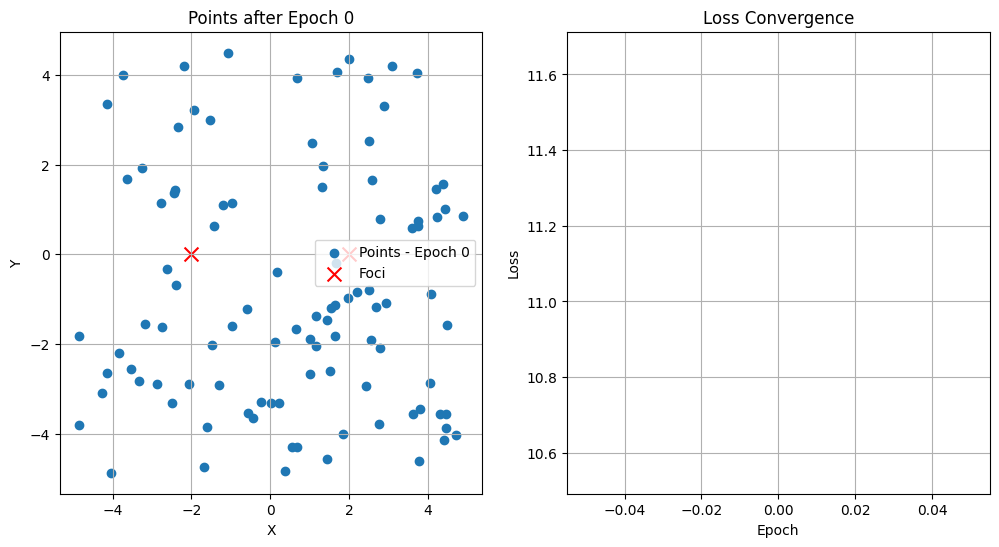

Elapsed time: 1.2498977184295654 seconds


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []


import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss - it is implemented as MSE loss related to l_2 norm
    # TODO: your job is to replace the line below
    # with l_0, l_1 and l_infty - related loss
    loss = torch.mean((dist1 + dist2 - constant_sum) **2)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)


# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")